# 13. 어제 오른 내 주식, 과연 내일은?

## 9. 프로젝트 : 주식 예측에 도전해 보자
ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았다. 이제 실제 주식값 예측에 도전해보자. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 아래 그림을 따라 하시면 다운로드할 수 있다.

<img src="./image/samsung.png" alt="samsung" />

우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해보자. 이를 위해서 "samsung"을 검색하고, "Historical Data" 탭에서 "Time Period"를 "Max"로 선택, "Apply" 버튼을 눌러 과거 삼성전자가 상장한 시점부터 가장 최근까지의 자료를 조회한다. 그리고 "Download"를 클릭하면 데이터를 다운로드를 할 수 있다. 다운로드가 완료되었다면 작업 디렉토리로 파일을 옮기면 된다. 실습환경에 따라 원본(source)과 사본(destination) 경로는 달라질 수 있다.

```bash
$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data
# 환경설정을 영어로 사용하는 경우는 아래 명령어를 입력하세요.
$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data
```

이후 순서는 다음과 같다.

### STEP 1 : 시계열 데이터 준비
---
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, Close만 사용하겠다. (주식 시장은 정해진 시간 동안만 거래가 가능하다. 종가란 하루의 장이 마감하였을 때의 가격이다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/samsung.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [2]:
ts

Date
2000-01-04     6110.0
2000-01-05     5580.0
2000-01-06     5620.0
2000-01-07     5540.0
2000-01-10     5770.0
               ...   
2021-02-24    82000.0
2021-02-25    85300.0
2021-02-26    82500.0
2021-03-02    83600.0
2021-03-03    84000.0
Name: Close, Length: 5320, dtype: float64

#### 함수 선언

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### STEP 2 : 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [5]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

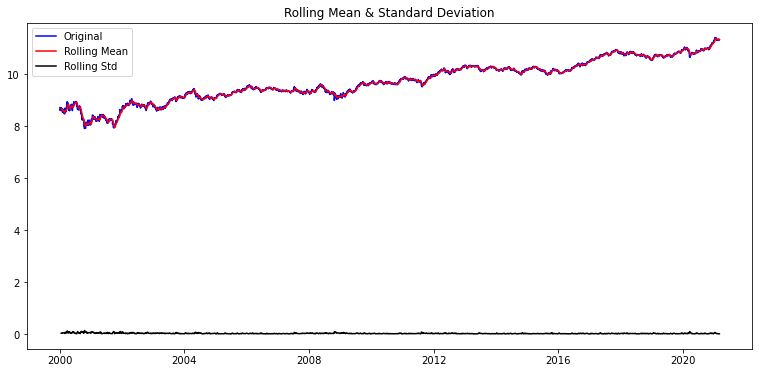

Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


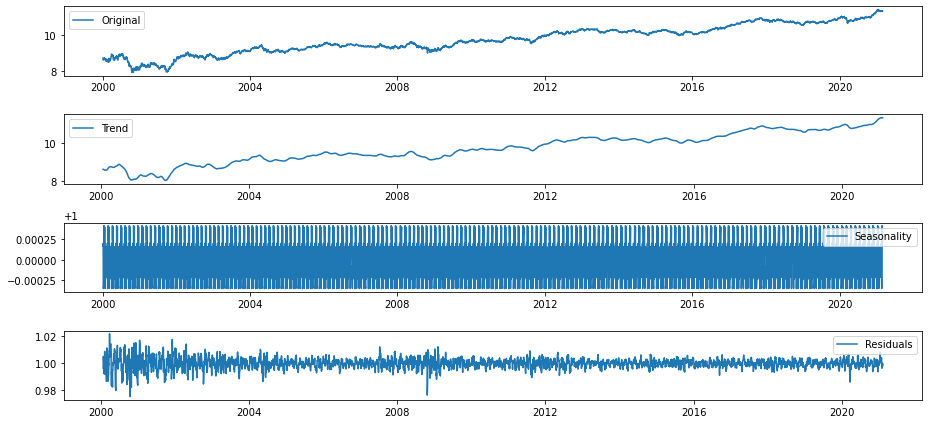

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리
* 2021년 최근 급등한 부분이 예측에 방해되는 것 같아서 잘라내었다.

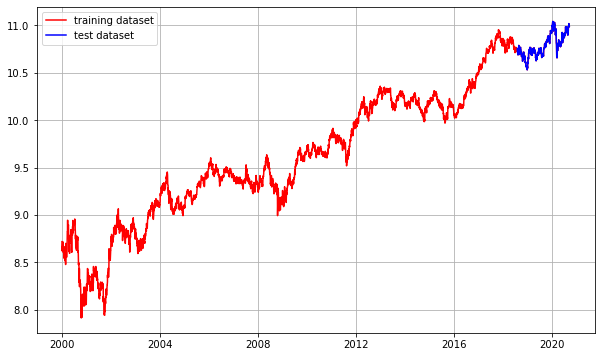

In [9]:
ts_log = ts_log[:int(len(ts_log)*0.98)] # 최근 급등한 부분을 잘라주었다.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

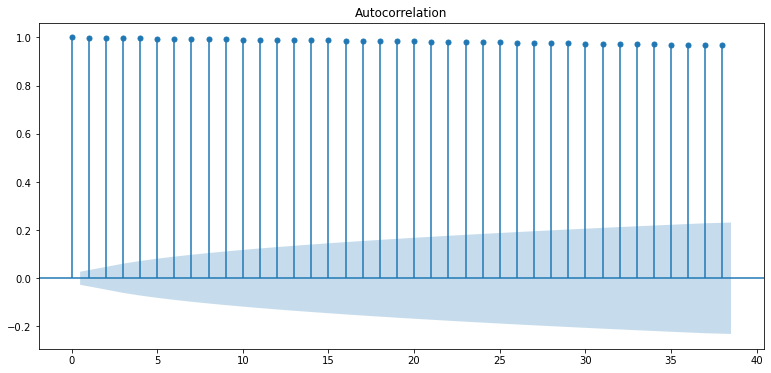

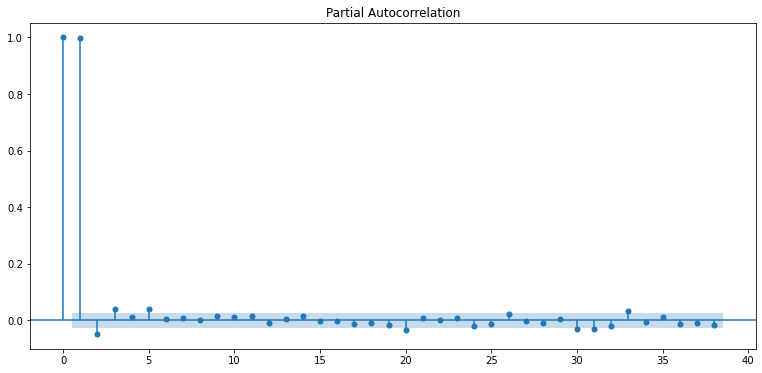

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.812213
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5208.000000
Critical Value (1%)              -3.431606
Critical Value (5%)              -2.862095
Critical Value (10%)             -2.567065
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.684408
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


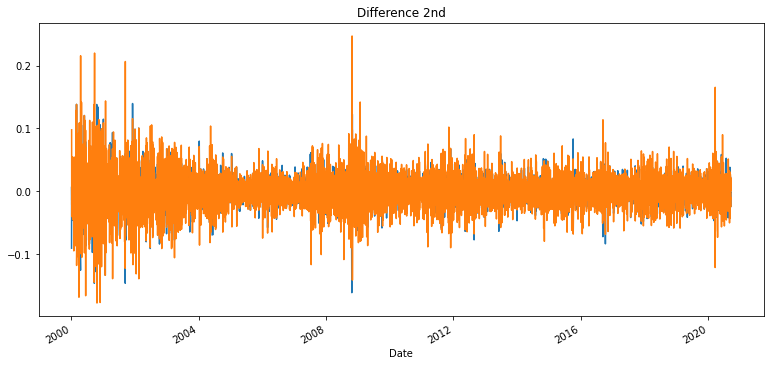

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트
---
* `my_auto_arima()` 함수를 이용하여 좋은 `p`,`d`, `q`를 찾기.
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

[my_auto_arima()](https://predictor-ver1.tistory.com/3)

이 블로그를 참조하여 함수를 만들었다.

In [12]:
from statsmodels.tsa.arima_model import ARIMA

def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [13]:
my_auto_arima(train_data,[3,3,3])

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

,order,AIC
19,p2 d1 q1,-22095.169191
13,p1 d1 q2,-22094.969865
20,p2 d1 q2,-22093.186273
17,p2 d0 q2,-22088.439626
18,p2 d1 q0,-22078.119954
4,p0 d1 q2,-22077.988394
10,p1 d0 q2,-22072.307982
12,p1 d1 q1,-22063.883020
16,p2 d0 q1,-22058.646519
3,p0 d1 q1,-22055.236046


In [14]:
# import itertools

# p = range(0, 3)
# d = range(1, 2)
# q = range(0, 3)
# pdq = list(itertools.product(p, d, q))

# aic = []
# for i in pdq:
#     model = ARIMA(train_data, order=(i))
#     model_fit = model.fit()
#     print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
#     aic.append(round(model_fit.aic,2))

`p2 d1 q1` 가 가장 좋은 성능을 낸 모수이다.

In [15]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(2, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4690
Model:                 ARIMA(2, 1, 1)   Log Likelihood               11052.585
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22095.169
Time:                        21:52:28   BIC                         -22062.903
Sample:                             1   HQIC                        -22083.824
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.536      0.124      -0.000       0.001
ar.L1.D.Close     0.6988      0.083      8.370      0.000       0.535       0.862
ar.L2.D.Close    -0.1036      0.015     

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


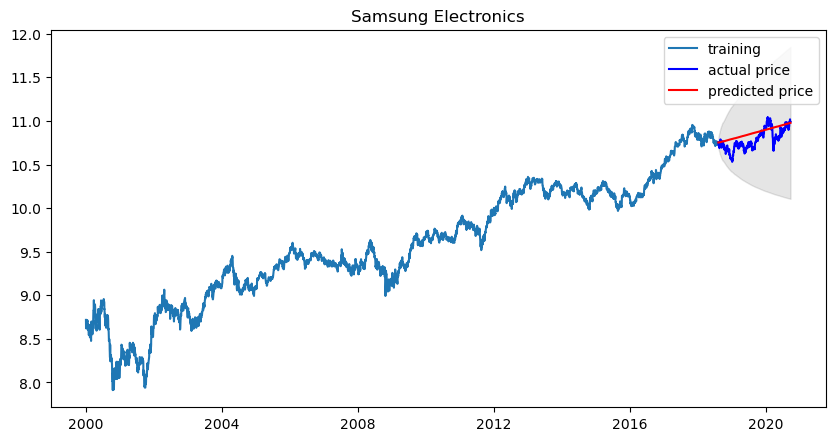

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('Samsung Electronics')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.savefig('./samsung.png')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27798956.350815687
MAE:  4556.200154352163
RMSE:  5272.471559981684
MAPE: 9.84%


### STEP 7 : 다른 주식 종목 예측해 보기
---
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### Kakao
---
2000년대 닷컴버블로 큰 변동성이 있었다. 예측이 잘 될지 궁금해서 추가했다.

In [18]:
dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/kakao.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-02-11    273000.0
2000-02-14    247000.0
2000-02-15    217500.0
2000-02-16    243500.0
2000-02-17    243500.0
Name: Close, dtype: float64

#### 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [19]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [20]:
# 로그 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

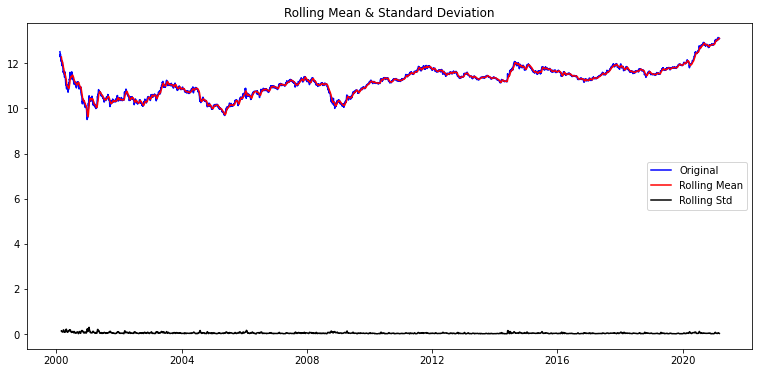

Results of Dickey-Fuller Test:
Test Statistic                   -1.209317
p-value                           0.669575
#Lags Used                        5.000000
Number of Observations Used    5286.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


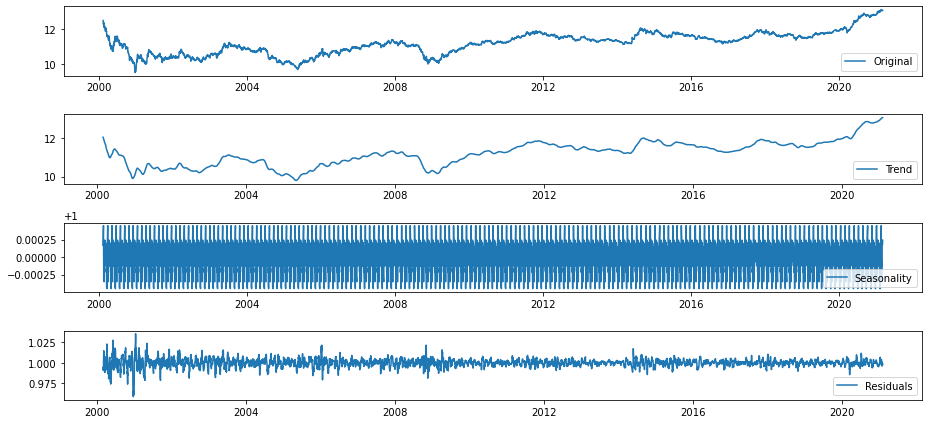

In [21]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.790623e+01
p-value                        2.940886e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.228000e+03
Critical Value (1%)           -3.431601e+00
Critical Value (5%)           -2.862093e+00
Critical Value (10%)          -2.567064e+00
dtype: float64


####  학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리

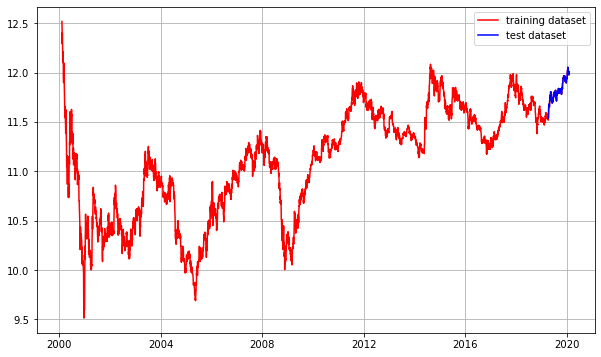

In [23]:
ts_log = ts_log[:int(len(ts_log)*0.95)]
train_data, test_data = ts_log[:int(len(ts_log)*0.96)], ts_log[int(len(ts_log)*0.96):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

차트를 보면 2000년대 시기 변동성이 굉장히 심한 것을 볼 수 있다. 그 시기는 [닷컴버블](https://namu.wiki/w/%EB%8B%B7%20%EC%BB%B4%20%EB%B2%84%EB%B8%94) 시기로 많은 it기업들의 주가가 요동을 쳤다.

<img src="./image/nasdaq.jpg" alt="NASDAQ" />
<center><b>닷컴버블 당시 나스닥 차트</b></center>


<img src="./image/kosdaq.jpg" alt="KOSDAQ" />
<center><b>닷컴버블 당시 코스닥 차트 <br>현재까지도 저당시의 가격에 미치지 못하고 있다.</b></center>

시계열 데이터로써 별로 좋은 모습은 아니므로 잘라내도록 하자.

최근 급등세가 지속된 부분도 좋은 데이터가 아니므로 잘라냈다.

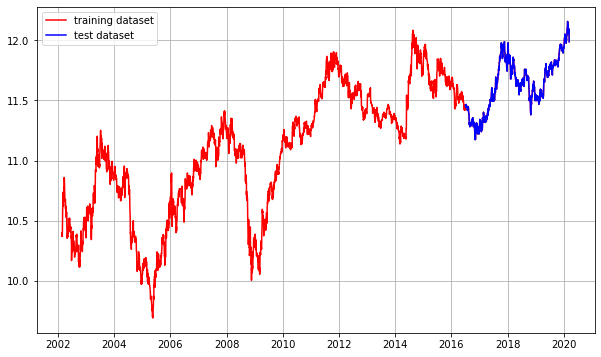

In [24]:
# 로그 변환 시도 
ts_log = np.log(ts)

ts_log = ts_log[int(len(ts_log)*0.1):]
ts_log = ts_log[:int(len(ts_log)*0.95)]
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

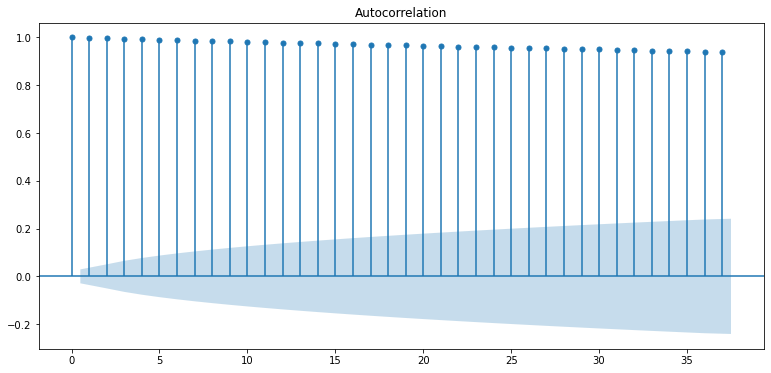

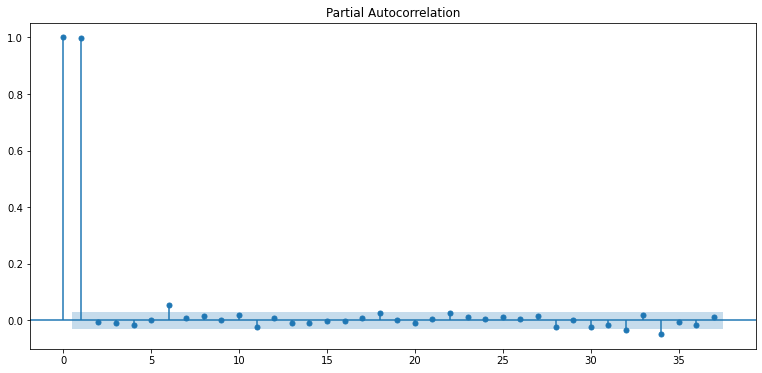

In [25]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.122206
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    4518.000000
Critical Value (1%)              -3.431798
Critical Value (5%)              -2.862180
Critical Value (10%)             -2.567111
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.688855
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    4489.000000
Critical Value (1%)              -3.431808
Critical Value (5%)              -2.862184
Critical Value (10%)             -2.567113
dtype: float64


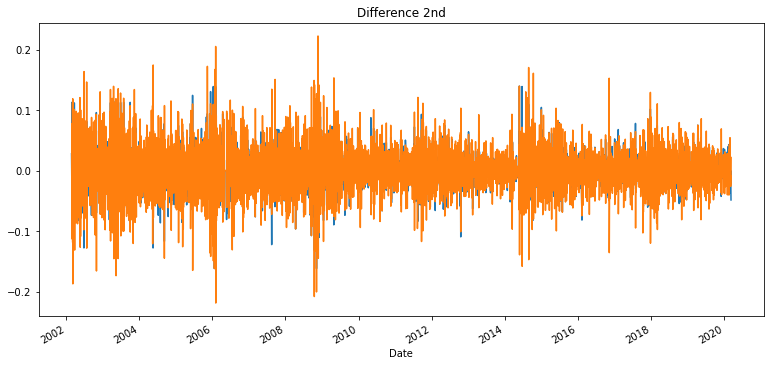

In [26]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 훈련과 테스트
---
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

마찬가지로 `my_auto_arima()`함수로 좋은 모수를 찾았다.

In [27]:
my_auto_arima(train_data,[3,3,3])

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

,order,AIC
23,p2 d1 q2,-15142.602953
13,p1 d1 q1,-15142.382260
3,p0 d1 q0,-15141.196974
19,p2 d0 q1,-15140.404670
9,p1 d0 q0,-15140.055304
14,p1 d1 q2,-15139.530570
22,p2 d1 q1,-15139.530570
4,p0 d1 q1,-15139.291415
12,p1 d1 q0,-15139.289406
20,p2 d0 q2,-15138.408155


`p2 d1 q2` 값이 나왔다.

In [28]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3618
Model:                 ARIMA(2, 1, 2)   Log Likelihood                7577.301
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 04 Mar 2021   AIC                         -15142.603
Time:                        21:52:51   BIC                         -15105.441
Sample:                             1   HQIC                        -15129.363
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      0.599      0.549      -0.001       0.001
ar.L1.D.Close    -0.5753      0.010    -58.878      0.000      -0.594      -0.556
ar.L2.D.Close    -0.9903      0.013    -

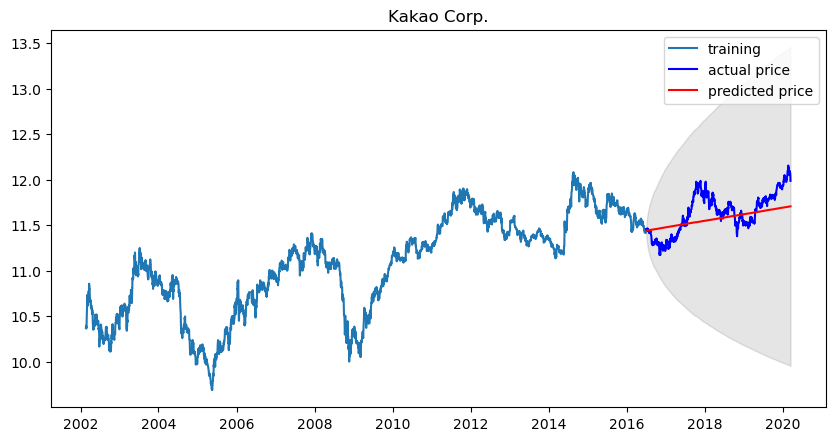

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('Kakao Corp.')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.savefig('./kakao.png')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  515759434.4107541
MAE:  17728.448106824908
RMSE:  22710.33761111345
MAPE: 14.41%


### Posco Chemical
---
최근 떠오르는 우상향 종목이다. 전기차 배터리 최대 수혜 기업이기도 하다.

In [31]:
dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/poscochem.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2001-11-02    1095.0
2001-11-05     965.0
2001-11-06     955.0
2001-11-07     895.0
2001-11-08     895.0
Name: Close, dtype: float64

#### 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [32]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [33]:
# 로그 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

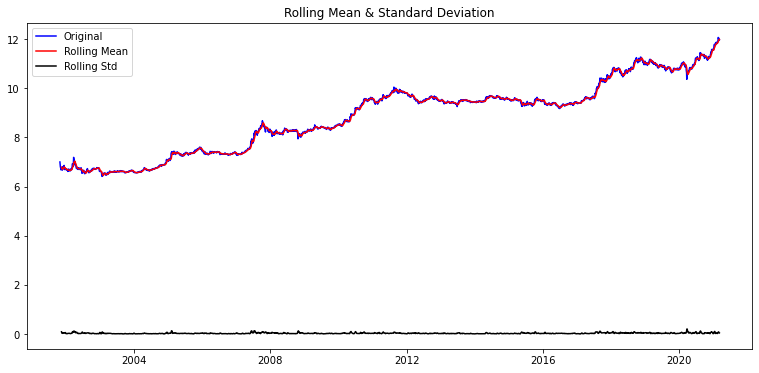

Results of Dickey-Fuller Test:
Test Statistic                    0.756908
p-value                           0.990908
#Lags Used                        0.000000
Number of Observations Used    4841.000000
Critical Value (1%)              -3.431702
Critical Value (5%)              -2.862137
Critical Value (10%)             -2.567088
dtype: float64


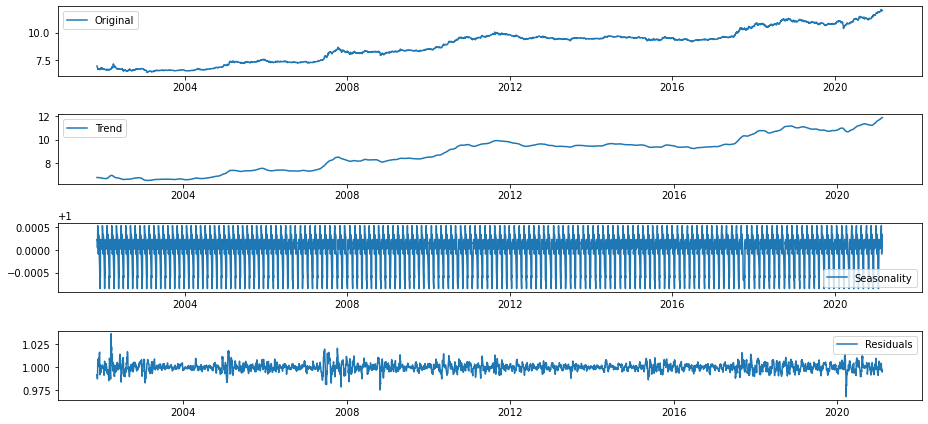

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.754068e+01
p-value                        4.190793e-30
#Lags Used                     3.100000e+01
Number of Observations Used    4.780000e+03
Critical Value (1%)           -3.431719e+00
Critical Value (5%)           -2.862145e+00
Critical Value (10%)          -2.567092e+00
dtype: float64


####  학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리
* 포스코케미칼은 2017년 부터 2021년 현재까지 급등했다. 마찬가지로 예측에 좋은 데이터는 아니므로 잘라내자.

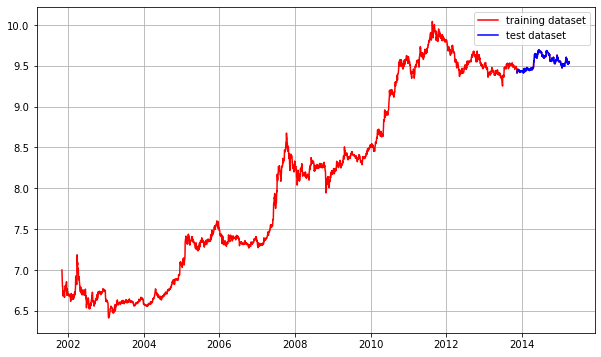

In [36]:
ts_log = ts_log[:int(len(ts_log)*0.7)]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

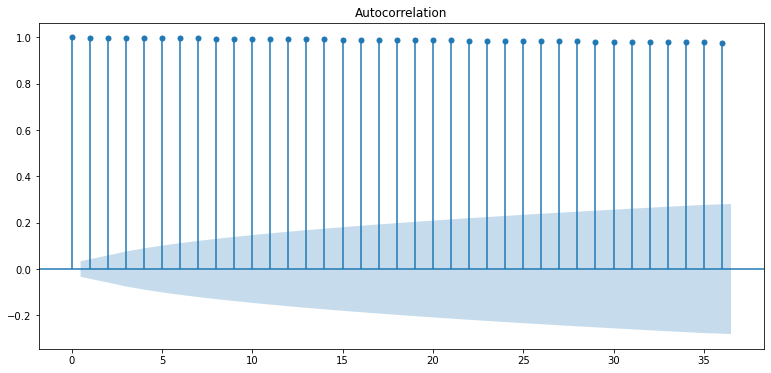

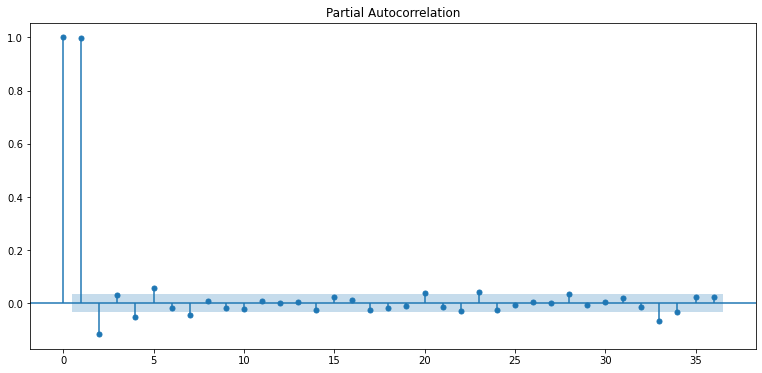

In [37]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -20.180038
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    3380.000000
Critical Value (1%)              -3.432286
Critical Value (5%)              -2.862395
Critical Value (10%)             -2.567225
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -19.032816
p-value                           0.000000
#Lags Used                       29.000000
Number of Observations Used    3357.000000
Critical Value (1%)              -3.432299
Critical Value (5%)              -2.862401
Critical Value (10%)             -2.567229
dtype: float64


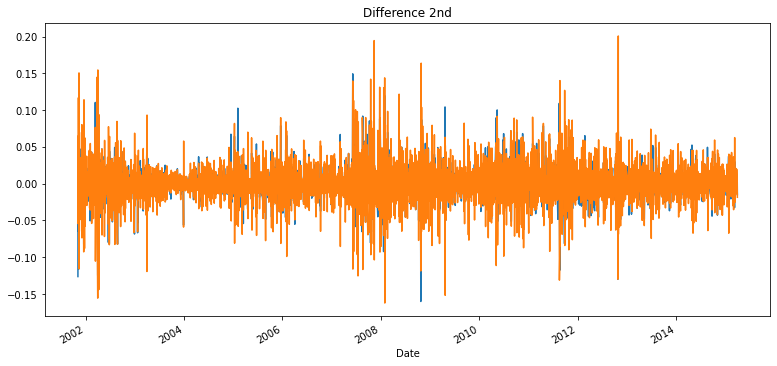

In [38]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 훈련과 테스트
---
* `my_auto_arima()` 함수를 이용하여 좋은 `p`,`d`, `q`를 찾기.
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [39]:
my_auto_arima(train_data,[3,3,3])

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

,order,AIC
12,p1 d1 q1,-14529.266976
19,p2 d1 q1,-14527.267095
20,p2 d1 q2,-14525.539469
4,p0 d1 q2,-14522.106287
18,p2 d1 q0,-14521.167820
3,p0 d1 q1,-14520.760168
17,p2 d0 q1,-14520.653061
11,p1 d1 q0,-14520.177069
2,p0 d1 q0,-14513.467169
10,p1 d0 q2,-14513.406002


`p1 d1 q1`가 가장 좋은 성능을 내는 모수이다.

In [40]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3049
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7268.633
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 04 Mar 2021   AIC                         -14529.267
Time:                        21:53:06   BIC                         -14505.177
Sample:                             1   HQIC                        -14520.609
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      1.920      0.055   -1.68e-05       0.002
ar.L1.D.Close    -0.6931      0.090     -7.731      0.000      -0.869      -0.517
ma.L1.D.Close     0.7516      0.082     

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


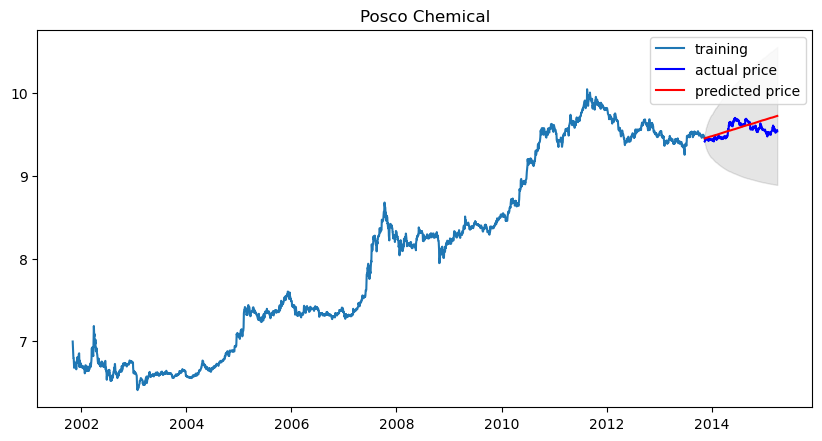

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('Posco Chemical')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.savefig('./poscochem.png')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1831259.0707493552
MAE:  1110.923276837114
RMSE:  1353.2402117692761
MAPE: 7.90%


### Google
---
전형적인 우상향 종목으로 Google이 떠올랐다. 예측해보자.

In [43]:
dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/alphabet.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

#### 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [44]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [45]:
# 로그 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

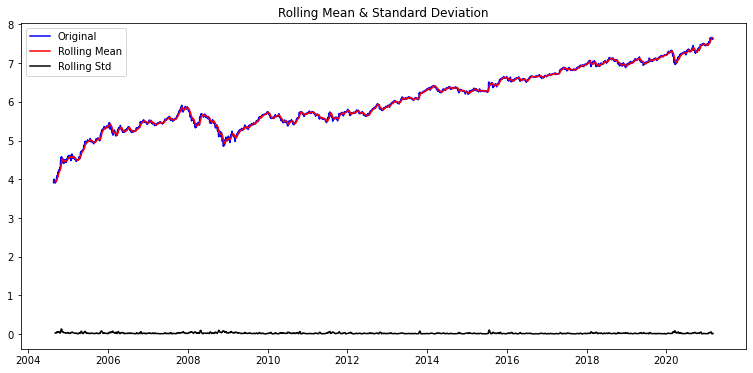

Results of Dickey-Fuller Test:
Test Statistic                   -1.856515
p-value                           0.352786
#Lags Used                        7.000000
Number of Observations Used    4154.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567141
dtype: float64


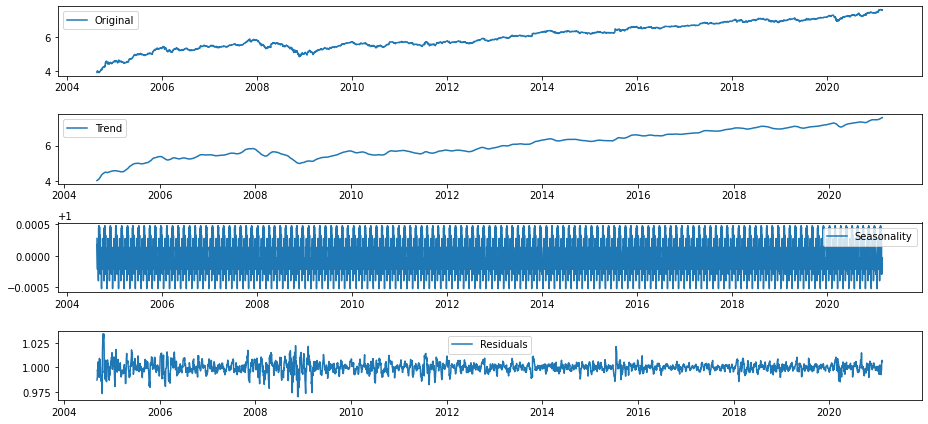

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.490394e+01
p-value                        1.492627e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.101000e+03
Critical Value (1%)           -3.431946e+00
Critical Value (5%)           -2.862245e+00
Critical Value (10%)          -2.567145e+00
dtype: float64


####  학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리

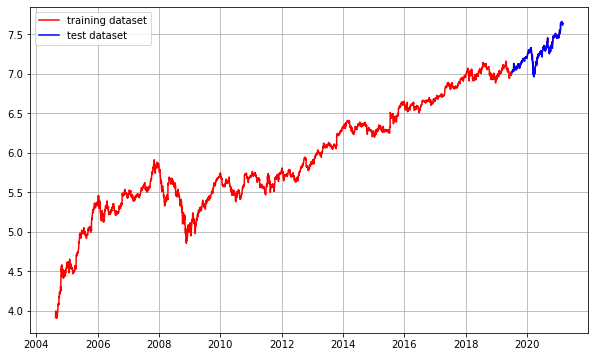

In [48]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

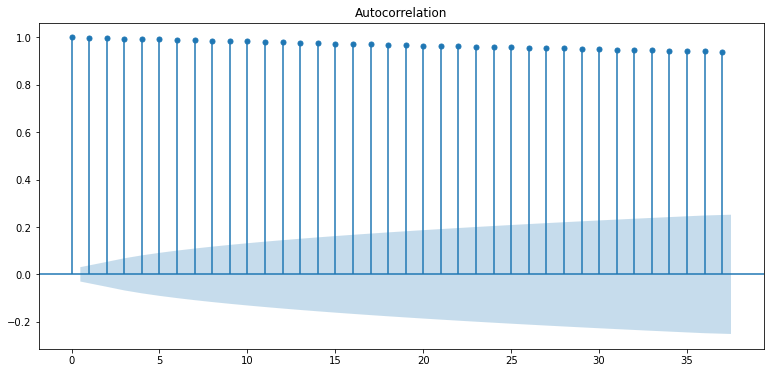

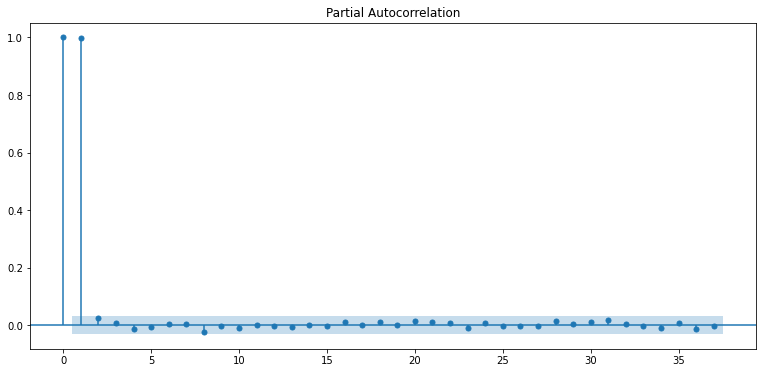

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.629414
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4154.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567141
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -20.560174
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4128.000000
Critical Value (1%)              -3.431935
Critical Value (5%)              -2.862240
Critical Value (10%)             -2.567143
dtype: float64


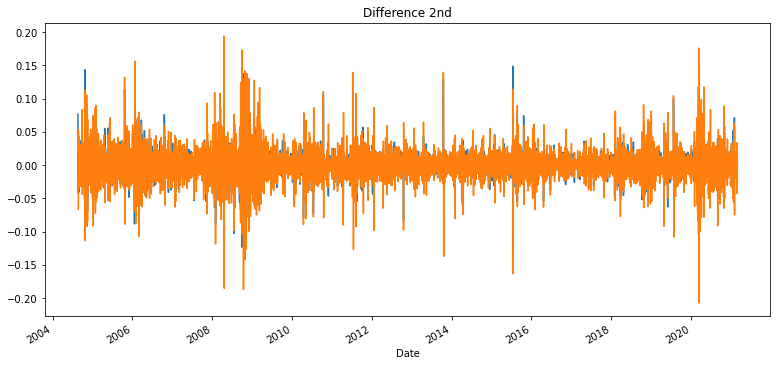

In [50]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 훈련과 테스트
---
* `my_auto_arima()` 함수를 이용하여 좋은 `p`,`d`, `q`를 찾기.
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [51]:
my_auto_arima(train_data,[3,3,3])

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

,order,AIC
23,p2 d1 q2,-19095.710014
3,p0 d1 q0,-19092.744192
4,p0 d1 q1,-19091.191906
12,p1 d1 q0,-19091.180120
21,p2 d1 q0,-19089.836599
5,p0 d1 q2,-19089.810026
13,p1 d1 q1,-19089.429295
14,p1 d1 q2,-19087.837851
22,p2 d1 q1,-19087.300177
9,p1 d0 q0,-19079.997665


`p2 d1 q2`가 좋은 성능을 내는 모수이다.

In [52]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(2, 1, 2))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3744
Model:                 ARIMA(2, 1, 2)   Log Likelihood                9553.855
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                         -19095.710
Time:                        21:53:26   BIC                         -19058.343
Sample:                             1   HQIC                        -19082.420
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.713      0.007       0.000       0.001
ar.L1.D.Close    -0.0373      0.025     -1.486      0.137      -0.086       0.012
ar.L2.D.Close    -0.9696      0.034    -

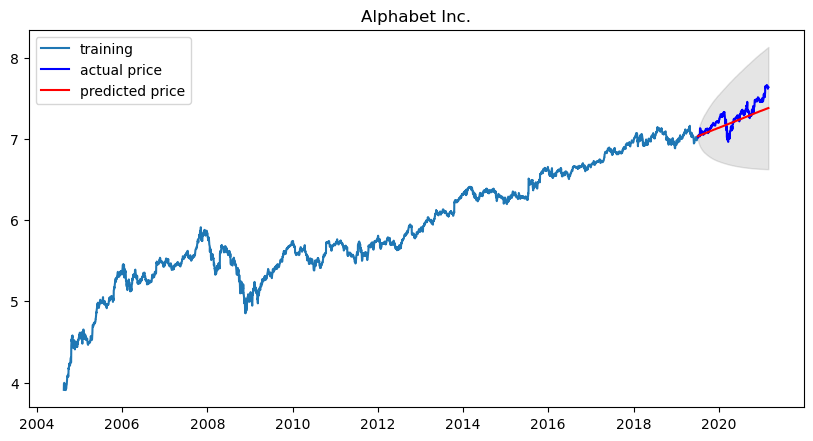

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('Alphabet Inc.')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.savefig('./google.png')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29450.59036532769
MAE:  126.46532959249885
RMSE:  171.61174308691025
MAPE: 8.02%


### Nexon
---
일본시장에 상장되어있는 게임회사 Nexon을 예측해보자.

In [55]:
dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/nexon.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2011-12-14    635.0
2011-12-15    622.0
2011-12-16    550.0
2011-12-19    530.0
2011-12-20    526.5
Name: Close, dtype: float64

#### 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [56]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [57]:
# 로그 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

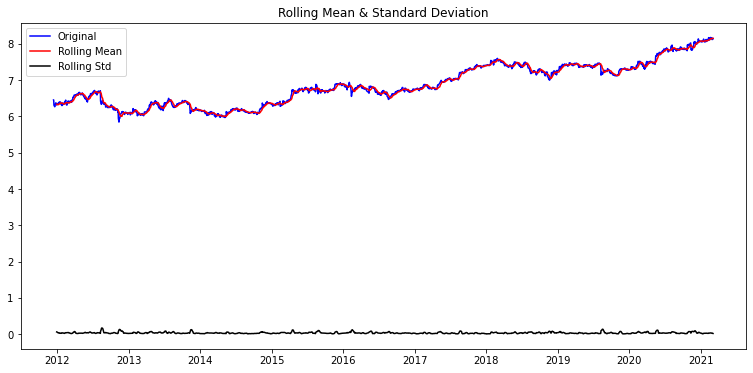

Results of Dickey-Fuller Test:
Test Statistic                   -0.214901
p-value                           0.936722
#Lags Used                        0.000000
Number of Observations Used    2274.000000
Critical Value (1%)              -3.433229
Critical Value (5%)              -2.862812
Critical Value (10%)             -2.567447
dtype: float64


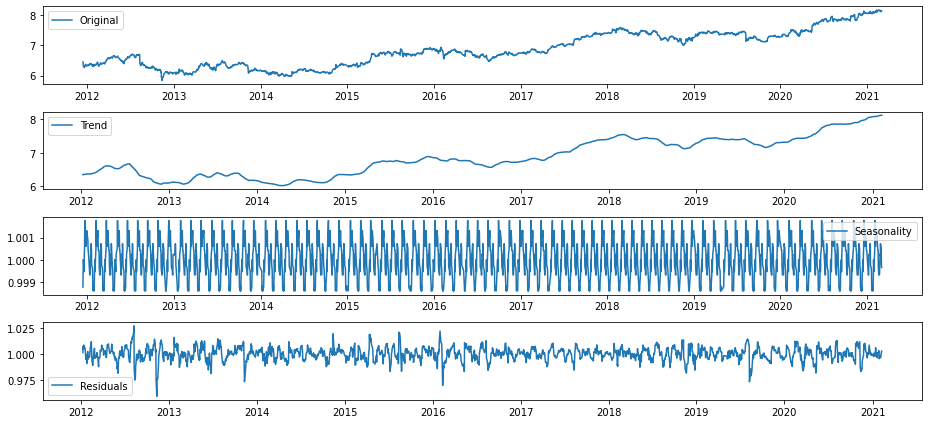

In [58]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [59]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.367902e+01
p-value                        1.412207e-25
#Lags Used                     2.500000e+01
Number of Observations Used    2.219000e+03
Critical Value (1%)           -3.433300e+00
Critical Value (5%)           -2.862843e+00
Critical Value (10%)          -2.567464e+00
dtype: float64


####  학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리
* 최근 급등세가 예측에 방해하기 때문에 잘라내주었다.

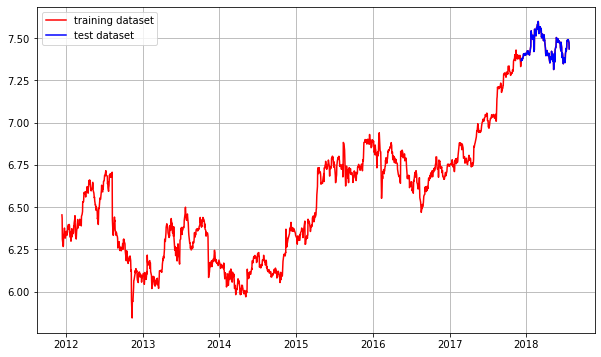

In [60]:
ts_log = ts_log[:int(len(ts_log)*0.72)]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

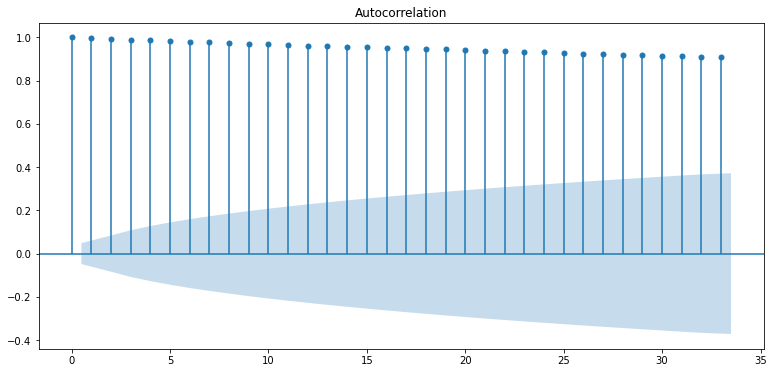

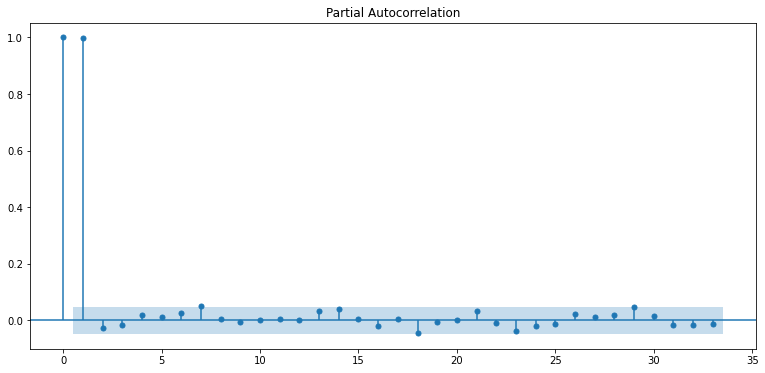

In [61]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.852554e+01
p-value                        2.106151e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.631000e+03
Critical Value (1%)           -3.434366e+00
Critical Value (5%)           -2.863314e+00
Critical Value (10%)          -2.567714e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.546206e+01
p-value                        2.697792e-28
#Lags Used                     2.200000e+01
Number of Observations Used    1.613000e+03
Critical Value (1%)           -3.434411e+00
Critical Value (5%)           -2.863334e+00
Critical Value (10%)          -2.567725e+00
dtype: float64


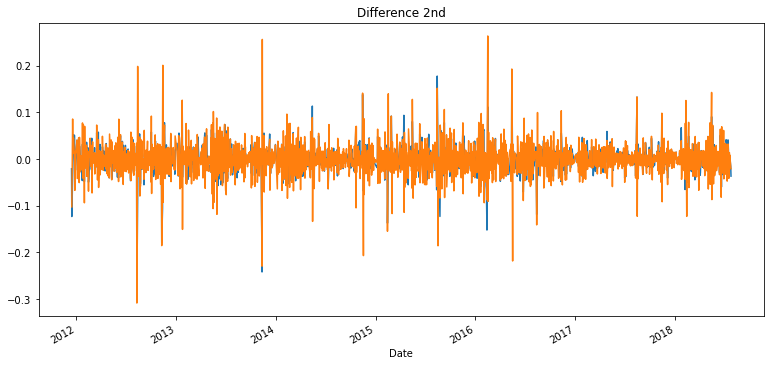

In [62]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 훈련과 테스트
---
* `my_auto_arima()` 함수를 이용하여 좋은 `p`,`d`, `q`를 찾기.
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [63]:
my_auto_arima(train_data,[3,3,3])

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

,order,AIC
23,p2 d1 q2,-6368.922945
3,p0 d1 q0,-6355.327071
13,p1 d1 q1,-6354.140519
12,p1 d1 q0,-6353.455421
4,p0 d1 q1,-6353.454688
22,p2 d1 q1,-6353.250869
14,p1 d1 q2,-6353.184046
9,p1 d0 q0,-6353.138701
5,p0 d1 q2,-6351.469823
21,p2 d1 q0,-6351.466116


`p2 d1 q2`가 가장 좋은 성능을 내는 모수이다.

In [64]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1473
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3181.070
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 04 Mar 2021   AIC                          -6354.141
Time:                        21:53:39   BIC                          -6332.960
Sample:                             1   HQIC                         -6346.243
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.001      1.102      0.271      -0.000       0.002
ar.L1.D.Close     0.9241      0.061     15.245      0.000       0.805       1.043
ma.L1.D.Close    -0.9409      0.053    -

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


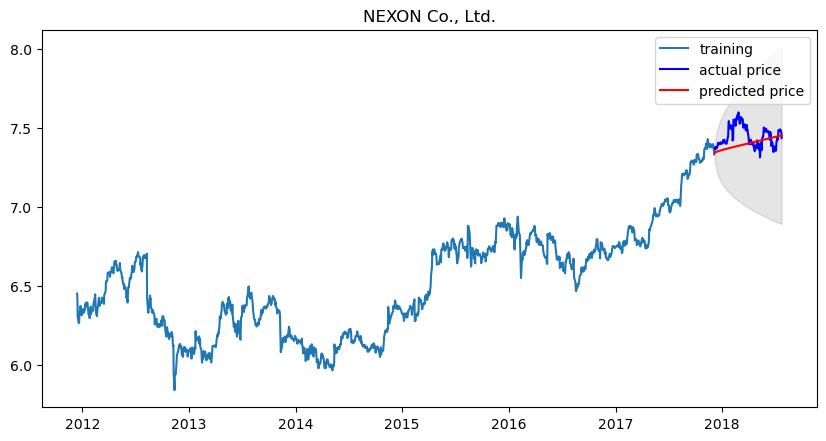

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('NEXON Co., Ltd.')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.savefig('./nexon.png')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22466.60113646497
MAE:  115.67721839417086
RMSE:  149.88862910996608
MAPE: 6.48%


### QQQ
---
[QQQ](https://namu.wiki/w/QQQ)는 미국 나스닥을 1배로 추종하는 상장 [ETF](https://namu.wiki/w/%EC%83%81%EC%9E%A5%EC%A7%80%EC%88%98%ED%8E%80%EB%93%9C?from=ETF)이다. 미국 나스닥에 상장되어 있는 주식중 금융주를 제외한 104가지 주식을 기초 자산으로 만들어진 ETF로 시총기준으로 가중 투자된 자신을 가지고 있다. 금융주가 제외된 주 보유 자산이 IT와 healthcare 부분이 포함되어 있는 전형적인 성장주 ETF이다.

이 종목을 선택한 이유는 미국나스닥을 추종하기 때문에 차트 증가세가 굉장히 완만하고 꾸준히 우상향이기에 좋은 정확도가 나올것 같아 선택했다.

In [67]:
dataset_filepath = os.getenv('HOME') + '/AIFFEL/Exploration/E13_ARIMA/qqq.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2002-01-02    40.110001
2002-01-03    41.500000
2002-01-04    41.669998
2002-01-07    41.209999
2002-01-08    41.490002
Name: Close, dtype: float64

#### 각종 전처리 수행
---
* 결측치 처리
* 로그 변환

In [68]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [69]:
# 로그 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

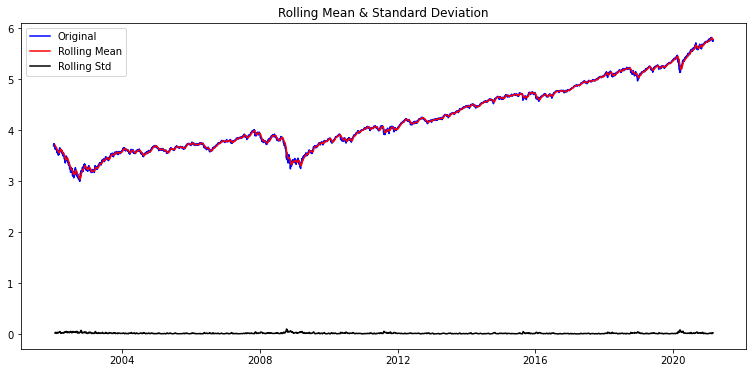

Results of Dickey-Fuller Test:
Test Statistic                    1.034810
p-value                           0.994620
#Lags Used                       16.000000
Number of Observations Used    4808.000000
Critical Value (1%)              -3.431711
Critical Value (5%)              -2.862141
Critical Value (10%)             -2.567090
dtype: float64


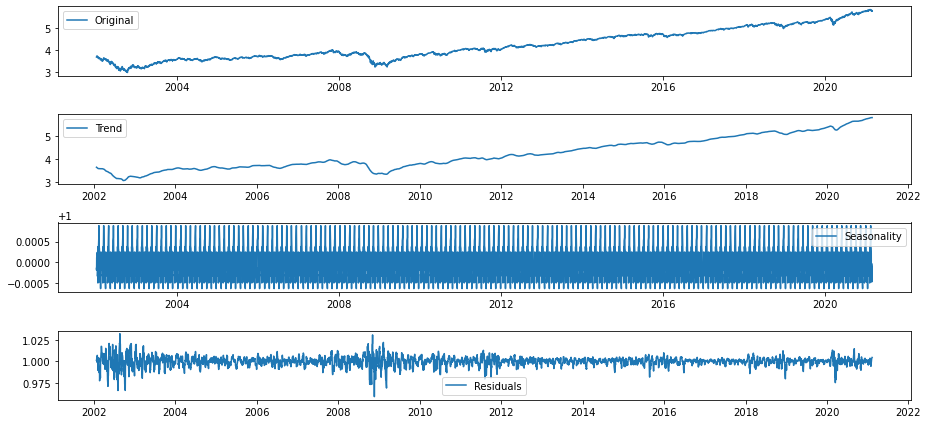

In [70]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [71]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.763940e+01
p-value                        3.765244e-30
#Lags Used                     3.200000e+01
Number of Observations Used    4.762000e+03
Critical Value (1%)           -3.431724e+00
Critical Value (5%)           -2.862147e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


####  학습, 테스트 데이터셋 생성
---
* 학습, 테스트 데이터셋 분리

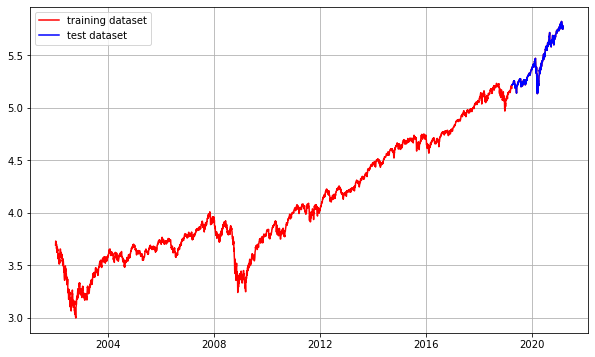

In [72]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

차트를 보면 2002년과 2008년에 큰 하락세가 보인다. 이유는 1999년 3월 10일 상장되어 911테러, IT버블과 2008년 금융위기를 겪은 ETF이기 때문에 금융 위기가 그대로 차트에 들어있다.

#### 적정 ARIMA 모수 찾기
---
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

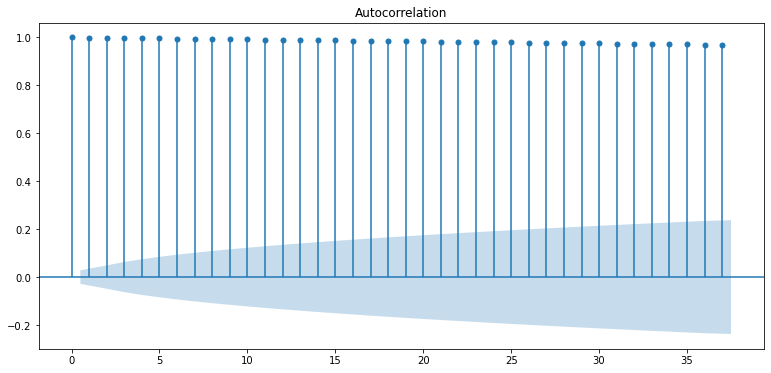

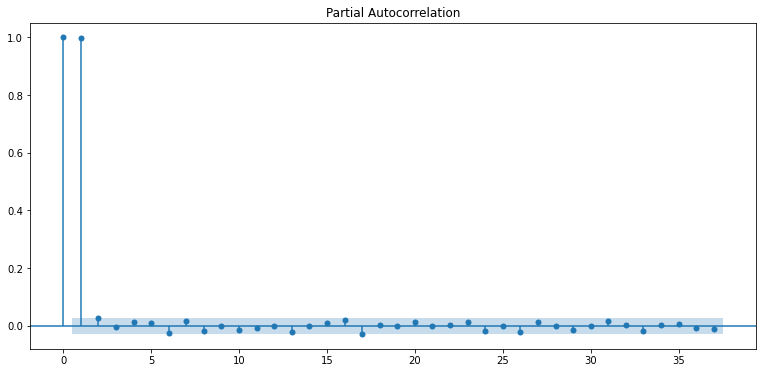

In [73]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.717724e+01
p-value                        6.683087e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.808000e+03
Critical Value (1%)           -3.431711e+00
Critical Value (5%)           -2.862141e+00
Critical Value (10%)          -2.567090e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.541498
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4791.000000
Critical Value (1%)              -3.431716
Critical Value (5%)              -2.862143
Critical Value (10%)             -2.567091
dtype: float64


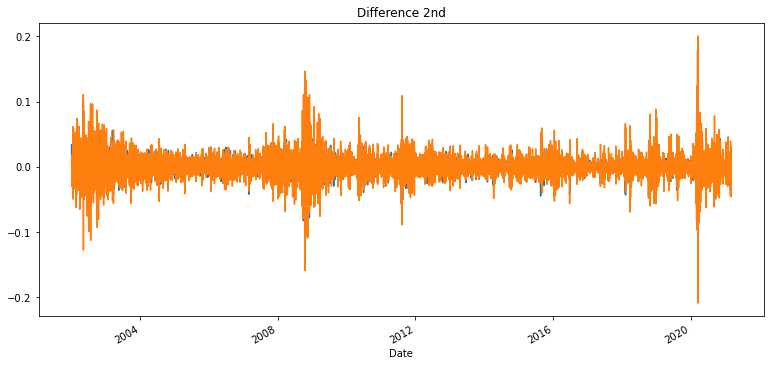

In [74]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 훈련과 테스트
---
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

모수가 `p0, d2, q8`일때 성능이 좋았다.

In [75]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p, d, q
model = ARIMA(train_data, order=(0, 2, 8))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 4340
Model:                 ARIMA(0, 2, 8)   Log Likelihood               12387.149
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 04 Mar 2021   AIC                         -24754.299
Time:                        21:53:49   BIC                         -24690.542
Sample:                             2   HQIC                        -24731.792
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.515e-07   6.34e-07      0.712      0.477   -7.92e-07    1.69e-06
ma.L1.D2.Close    -1.0597      0.015    -71.311      0.000      -1.089      -1.031
ma.L2.D2.Close     0.0071      0.023

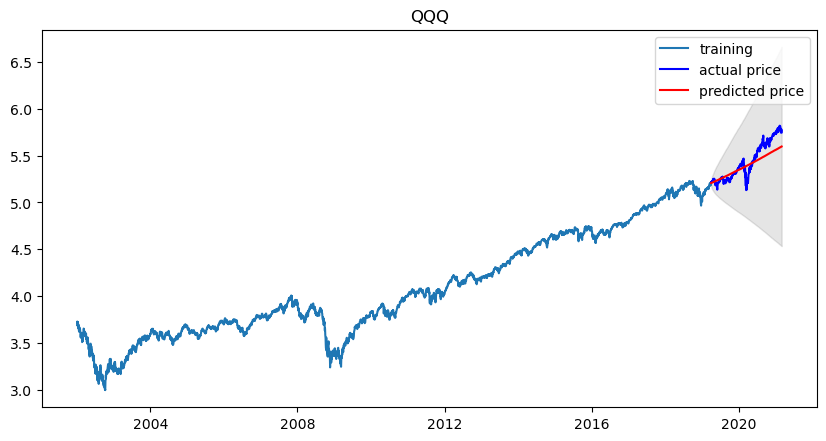

In [76]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('QQQ')
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.savefig('./qqq.png')
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  776.5348574725028
MAE:  20.408359149951252
RMSE:  27.866375032868966
MAPE: 7.83%


### 회고
---
* 시계열 안정성 분석 부분의 용어가 어렵고 수식이 많아 어려웠다.
* 그래도 ARIMA를 이용하니 간단한 코드로 수행 할 수 있었다.
* `my_auto_arima()` 함수를 사용하여 적절한 모수를 찾아낼 수 있었다.
* 그러나 적절한 모수를 찾아내는 것보다 데이터를 다듬어 주는 것이 더 좋은 성능을 내었다.
* 데이터를 다듬어 주면서 그 종목의 히스토리를 알게되어 재미있었다.
* 여러가지 모수를 넣어보고 데이터도 전처리하면서 다양한 시도를 해보았지만 어떤 차트의 정확도가 더 잘나오는지는 잘 모르겠다.
* __결국 데이터를 정확도에 맞추려고 다듬다보니 예측의 의미가 많이 사라진것 같다.__

![samsung](./samsung.png)


__삼성전자 예측 차트__
* __MAPE: 9.84%__
* __최근 급등세 차트가 예측에 방해되는 것 같아 제거해주었다.__

![kakao](./kakao.png)

__카카오 예측 차트__
* __MAPE: 14.41%__
* __최근 급등세와 2000년대 닷컴버블의 차트가 예측에 방해되는 것 같아 제거해주었다.__

![posco chemical](./poscochem.png)

__포스코 케미칼 예측 차트__
* __MAPE: 7.90%__
* __최근 급등세가 예측에 방해되는 것 같아 제거해주었다.__

![Alphabet](./google.png)

__Alphabet 예측 차트__
* __MAPE: 8.02%__
* __완만한 우상향 차트로 데이터를 제거하지 않아도 정확도가 잘 나왔다.__

![nexon](./nexon.png)

__넥슨 예측 차트__
* __MAPE: 6.48%__
* __최근 급등세가 예측에 방해되는 것 같아 제거해주었다.__

![QQQ](./qqq.png)

__QQQ 예측 차트__
* __MAPE: 7.83%__
* __완만한 우상향 차트로 데이터를 제거하지 않아도 정확도가 잘 나왔다.__

### 루브릭
---
* 시계열의 안정성이 충분히 확인되었는가?<br>
(_플로팅과 adfuller 메소드가 모두 적절히 사용되었음_)

    * __플로팅과 adfuller 메소드가 모두 적절히 사용되어 시계열의 안정성이 충분히 확인되었다.__

* ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?<br>
( _p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨_)
    
    * __p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정을 진행했고, 추가 성능 향상을 위해 `my_auto_arima()` 함수를 이용하여 좋은 `p`,`d`, `q`를 찾았다.__

* 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?<br>
(_3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨_)
    
    * __삼성전자, 카카오, 포스코케미칼, 구글, 넥슨, QQQ 전부 MAPE가 10% 미만의 정확도로 예측되었다.__